In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KDTree
from sklearn.preprocessing import normalize
import time
from scipy.stats import mode
from torchvision import datasets, transforms

# Загрузка данных
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Преобразование данных в numpy массивы
def dataset_to_numpy(dataset):
    data = dataset.data.numpy()
    data = data.reshape(data.shape[0], -1).astype('float32')
    return data

X_train = dataset_to_numpy(train_dataset)
X_test = dataset_to_numpy(test_dataset)

# Нормализация данных
X_train = normalize(X_train)
X_test = normalize(X_test)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (60000, 784)
Размер тестовой выборки: (10000, 784)


In [18]:
# Создание индекса FLAT
dimension = X_train.shape[1]
index_flat = faiss.IndexFlatL2(dimension)
index_flat.add(X_train)
print(f"Количество векторов в индексе FLAT: {index_flat.ntotal}")


Количество векторов в индексе FLAT: 60000


In [19]:
# Параметры для IVF
nlist = 100
quantizer = faiss.IndexFlatL2(dimension)
index_ivf = faiss.IndexIVFFlat(quantizer, dimension, nlist, faiss.METRIC_L2)


In [20]:
# Тренировка индекса
index_ivf.train(X_train)
if index_ivf.is_trained:
    index_ivf.add(X_train)
    print(f"Количество векторов в индексе IVF: {index_ivf.ntotal}")
else:
    print("Ошибка тренировки индекса IVF")

Количество векторов в индексе IVF: 60000


In [34]:
# Проверка поддержки индекса HNSW
try:
    index_hnsw = faiss.IndexHNSWFlat(dimension, 128)
    index_hnsw.hnsw.efConstruction = 128 
    index_hnsw.add(X_train)
    index_hnsw.hnsw.efSearch = 64
    
    print(f"Количество векторов в индексе HNSW: {index_hnsw.ntotal}")
    
except AttributeError:
    print("Индекс HNSW не поддерживается в вашей версии FAISS.")
except Exception as e:
    print(f"Произошла ошибка при создании индекса HNSW: {e}")

Количество векторов в индексе HNSW: 60000


In [35]:
# Функция для вычисления точности
def compute_accuracy(true_labels, train_labels, indices, k=5):
    top_k_labels = train_labels[indices[:, :k]]
    predicted_labels, _ = mode(top_k_labels, axis=1)
    predicted_labels = predicted_labels.flatten()
    accuracy = accuracy_score(true_labels, predicted_labels)
    return accuracy

In [36]:
# Функция для бенчмаркинга FAISS
def benchmark_faiss(index, index_name, X_test, labels_test, k_values, train_labels):
    results = []
    
    for k in k_values:
        start_time = time.time()
        distances, indices = index.search(X_test, k)
        search_time = time.time() - start_time
        
        accuracy = compute_accuracy(labels_test, train_labels, indices, k)
        
        results.append({
            'Индекс': index_name,
            'k': k,
            'Время поиска (сек)': search_time,
            'Точность': accuracy
        })
        print(f"{index_name} - k={k}: Время={search_time:.4f} сек, Точность={accuracy:.4f}")
    
    return results

In [37]:
# Бенчмаркинг KD-дерева
def benchmark_kdtree(kdtree, X_test, labels_test, k_values):
    results = []
    
    for k in k_values:
        start_time = time.time()
        distances, indices = kdtree.query(X_test, k=k)
        search_time = time.time() - start_time
        
        accuracy = compute_accuracy(labels_test, labels_train, indices, k)
        
        results.append({
            'Индекс': 'KD-Tree',
            'k': k,
            'Время поиска (сек)': search_time,
            'Точность': accuracy
        })
        print(f"KD-Tree - k={k}: Время={search_time:.4f} сек, Точность={accuracy:.4f}")
    
    return results 

In [40]:
# Получение истинных меток
labels_train = train_dataset.targets.numpy()
labels_test = test_dataset.targets.numpy()

In [41]:
k_values = [10, 50, 100, 200, 500, 700, 1000, 1500]

# Бенчмаркинг индексов FAISS
results_flat = benchmark_faiss(index_flat, 'FLAT', X_test, labels_test, k_values, labels_train)
results_ivf = benchmark_faiss(index_ivf, 'IVF', X_test, labels_test, k_values, labels_train)

if index_hnsw is not None:
    results_hnsw = benchmark_faiss(index_hnsw, 'HNSW', X_test, labels_test, k_values, labels_train)
else:
    results_hnsw = [{'k': k, 'Время поиска (сек)': np.nan, 'Точность': np.nan} for k in k_values]

# Бенчмаркинг KD-дерева
kd_tree = KDTree(X_train, leaf_size=40, metric='euclidean')
results_kdtree = benchmark_kdtree(kd_tree, X_test, labels_test, k_values)

FLAT - k=10: Время=379.9240 сек, Точность=0.8529
FLAT - k=50: Время=374.7315 сек, Точность=0.8211
FLAT - k=100: Время=374.8112 сек, Точность=0.8017
FLAT - k=200: Время=375.0076 сек, Точность=0.7836
FLAT - k=500: Время=374.8640 сек, Точность=0.7469
FLAT - k=700: Время=375.1648 сек, Точность=0.7372
FLAT - k=1000: Время=391.7215 сек, Точность=0.7220
FLAT - k=1500: Время=386.5404 сек, Точность=0.7055
IVF - k=10: Время=2.1727 сек, Точность=0.8411
IVF - k=50: Время=1.6747 сек, Точность=0.8151
IVF - k=100: Время=1.6825 сек, Точность=0.8013
IVF - k=200: Время=1.5680 сек, Точность=0.7899
IVF - k=500: Время=1.6026 сек, Точность=0.7563
IVF - k=700: Время=1.6619 сек, Точность=0.7035
IVF - k=1000: Время=1.6899 сек, Точность=0.6240
IVF - k=1500: Время=1.6705 сек, Точность=0.4032
HNSW - k=10: Время=5.3568 сек, Точность=0.8527
HNSW - k=50: Время=5.3163 сек, Точность=0.8211
HNSW - k=100: Время=5.2867 сек, Точность=0.8017
HNSW - k=200: Время=5.3025 сек, Точность=0.7835
HNSW - k=500: Время=5.2734 сек, То

In [42]:
# Создание DataFrame для результатов
def aggregate_results(results, index_name):
    df = pd.DataFrame(results)
    df['Индекс'] = index_name
    return df

df_flat = aggregate_results(results_flat, 'FLAT')
df_ivf = aggregate_results(results_ivf, 'IVF')
df_hnsw = aggregate_results(results_hnsw, 'HNSW')
df_kdtree = aggregate_results(results_kdtree, 'KD-Tree')

In [43]:
# Объединение всех результатов
benchmark_df = pd.concat([df_flat, df_ivf, df_hnsw, df_kdtree], ignore_index=True)
summary_df = benchmark_df.groupby('Индекс').agg({
    'Время поиска (сек)': 'mean',
    'Точность': 'mean'
}).reset_index()

print("\nСводная таблица результатов:")
print(summary_df)



Сводная таблица результатов:
    Индекс  Время поиска (сек)  Точность
0     FLAT          379.095627  0.771362
1     HNSW            5.304236  0.778775
2      IVF            1.715345  0.716800
3  KD-Tree          645.531045  0.771362


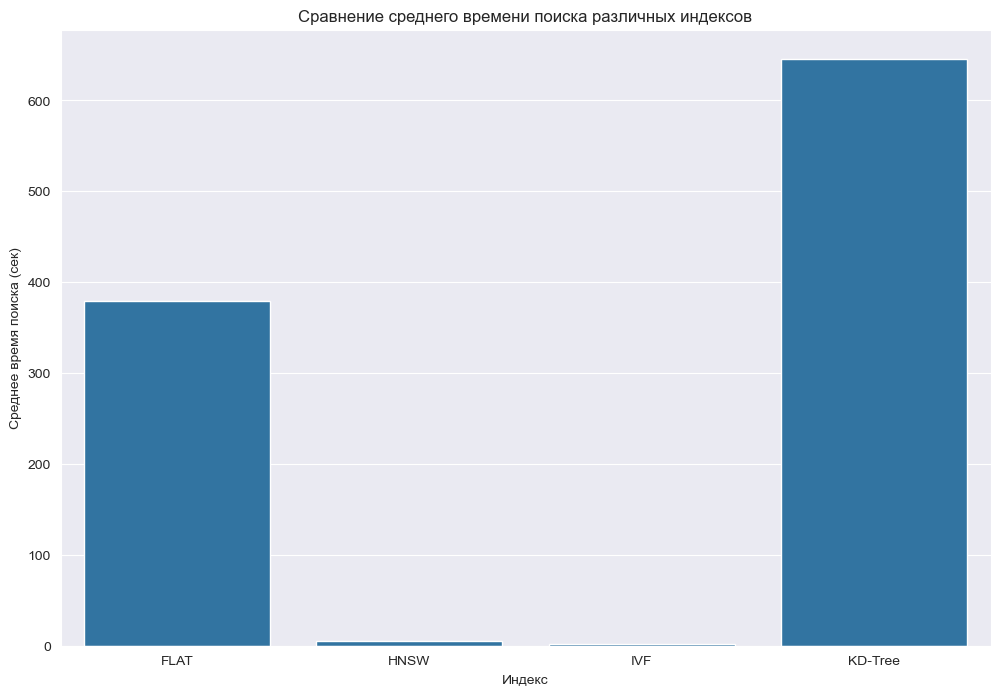

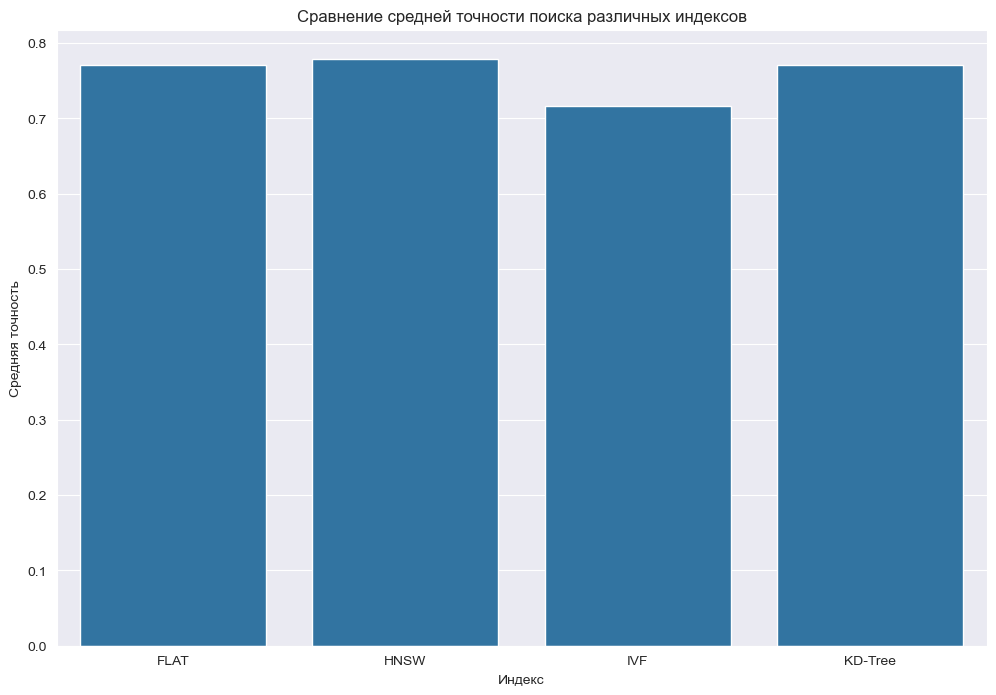

In [44]:
# Визуализация
plt.figure(figsize=(12, 8))
sns.barplot(x='Индекс', y='Время поиска (сек)', data=summary_df)
plt.title('Сравнение среднего времени поиска различных индексов')
plt.xlabel('Индекс')
plt.ylabel('Среднее время поиска (сек)')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='Индекс', y='Точность', data=summary_df)
plt.title('Сравнение средней точности поиска различных индексов')
plt.xlabel('Индекс')
plt.ylabel('Средняя точность')
plt.show()
